# Prep

In [11]:
import tensorflow as tf
import os
import random
# import cv2
import numpy as np

# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print(gpu_devices)
for device in gpu_devices:
  tf.config.experimental.set_memory_growth(device, True)

tf.keras.mixed_precision.set_global_policy('mixed_float16')

dataset_percent = 0.5
batch_size = 4
image_dimensions = (512, 512)

training_presets_subfolder_name = f'142_class/{str(image_dimensions[0])}'

model_filepath = f'./models/142_class/fastener_net_142_{str(image_dimensions[0])}_{str(int(dataset_percent*100))}_bigger.keras'
model_filepath_new = f'./models/142_class/fastener_net_142_{str(image_dimensions[0])}_{str(int(dataset_percent*100))}_bigger_new.keras'
pretrained_model_filepath_keras = f'./models/142_class/fastener_net_142_{str(image_dimensions[0])}_{str(int(dataset_percent*100))}_pre_trained.h5'
finetuned_model_filepath = f'./models/142_class/fastener_net_142_{str(image_dimensions[0])}_{str(int(dataset_percent*100))}_fine_tuned.h5'

model_results_filepath = f'./model_results/{str(image_dimensions[0])}_{str(int(dataset_percent*100))}_142_class'

print(training_presets_subfolder_name)
print(model_filepath)

# Important!
include_other_class = True

if include_other_class:
  num_classes = 142
else:
  num_classes = 129

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
142_class/512
./models/142_class/fastener_net_142_512_50_bigger.keras


In [1]:
%reset -f

# Prepare Data - 3 File Version

### Load

In [3]:
import pickle

training_set_file_path = f"./datasets/{training_presets_subfolder_name}/training_set.pkl"
validation_set_file_path = f"./datasets/{training_presets_subfolder_name}/validation_set.pkl"
test_set_file_path = f"./datasets/{training_presets_subfolder_name}/test_set.pkl"

with open(training_set_file_path, "rb") as file:
  print('Loading training set...')
  train_set = pickle.load(file)
  print('Done!')
  
with open(validation_set_file_path, "rb") as file:
  print('Loading validation set...')
  validation_set = pickle.load(file)
  print('Done!')
  
with open(test_set_file_path, "rb") as file:
  print('Loading test set...')
  test_set = pickle.load(file)
  print('Done!')

FileNotFoundError: [Errno 2] No such file or directory: './datasets/142_class/128/training_set.pkl'

### Format

We need to encode the dataset so the classes go from 0 to n with increment 1

In [3]:
from sklearn.preprocessing import LabelEncoder

all_labels = [label for _, label in train_set] + [label for _, label in validation_set] + [label for _, label in test_set]

label_encoder = LabelEncoder()

label_encoder.fit(all_labels)

train_set_encoded = [(image, label_encoder.transform([label])[0]) for image, label in train_set]

validation_set_encoded = [(image, label_encoder.transform([label])[0]) for image, label in validation_set]

test_set_encoded = [(image, label_encoder.transform([label])[0]) for image, label in test_set]

print(f'{len(train_set)} == {len(train_set_encoded)}')

with open(encoder_filepath, "wb") as file:
  print('Saving encoder...')
  pickle.dump(label_encoder, file)
  print('Done!')

del train_set, validation_set, test_set, label_encoder

11809 == 11809
Saving encoder...
Done!


In [4]:
(train_images, train_labels) = zip(*train_set_encoded)
(validation_images, validation_labels) = zip(*validation_set_encoded)
(test_images, test_labels) = zip(*test_set_encoded)

del train_set_encoded, validation_set_encoded, test_set_encoded

train_images = np.array(train_images)
train_labels = np.array([int(label) for label in train_labels])
validation_images = np.array(validation_images)
validation_labels = np.array([int(label) for label in validation_labels])
test_images = np.array(test_images)
test_labels = np.array([int(label) for label in test_labels])

##### Optional: View Data

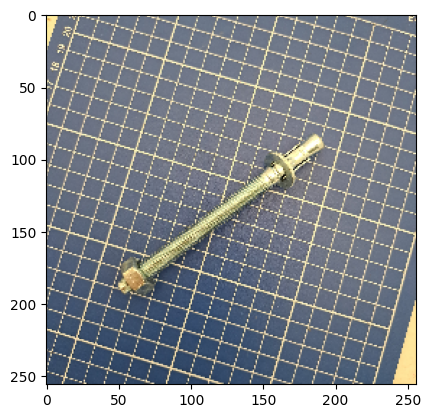

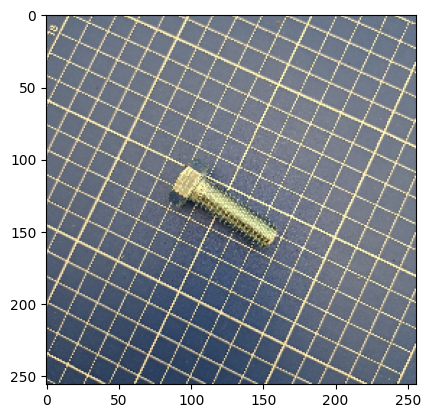

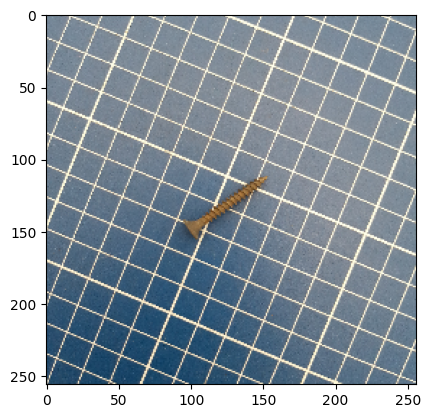

In [6]:
import matplotlib.pyplot as plt

# print(train_images[random.randint(0, len(train_images))])
train_im = train_images[random.randint(0, len(train_images))].astype(np.short)
validation_im = validation_images[random.randint(0, len(validation_images))].astype(np.short)
test_im = test_images[random.randint(0, len(test_images))].astype(np.short)

plt.imshow(train_im); plt.show()
plt.imshow(validation_im); plt.show()
plt.imshow(test_im); plt.show()

##### Create TF Dataset

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size)
del train_images, train_labels

2024-05-29 09:09:05.087261: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-29 09:09:05.092964: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-29 09:09:05.098556: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels)).batch(batch_size)
del validation_images, validation_labels

2024-05-29 09:09:14.052666: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 502530048 exceeds 10% of free system memory.
2024-05-29 09:09:14.169346: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 502530048 exceeds 10% of free system memory.


In [7]:
# test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)
del test_images, test_labels

# Prepare Data - New Version

### Load

In [2]:
import pickle

if include_other_class is True:
  dataset_filepath = f"./datasets/{training_presets_subfolder_name}/full_dataset.pkl"
else:
  dataset_filepath = f"./datasets/{training_presets_subfolder_name}/full_dataset_NO_OTHER.pkl"

with open(dataset_filepath, "rb") as file:
  print('Loading dataset...')
  dataset = pickle.load(file)
  print('Done!')

Loading dataset...
Done!


### Reduce

In [3]:
dataset = dataset[:int(len(dataset) * dataset_percent)]

### Format

In [3]:
from sklearn.preprocessing import LabelEncoder

if include_other_class is True:
  encoder_filepath = f"./datasets/{training_presets_subfolder_name}/encoder.pkl"
else:
  encoder_filepath = f"./datasets/{training_presets_subfolder_name}/encoder_NO_OTHER.pkl"

all_labels = [label for _, label in dataset]

label_encoder = LabelEncoder()

label_encoder.fit(all_labels)

dataset_encoded = [(image, label_encoder.transform([label])[0]) for image, label in dataset]

print(f'{len(dataset)} == {len(dataset_encoded)}')

if include_other_class == True:
  with open(encoder_filepath, "wb") as file:
    print('Saving encoder...')
    pickle.dump(label_encoder, file)
    print('Done!')
else:
  with open(encoder_filepath, "wb") as file:
    print('Saving encoder...')
    pickle.dump(label_encoder, file)
    print('Done!')

8479 == 8479
Saving encoder...
Done!


In [4]:
import json

with open('./datasets/category_count.json', 'rb') as file:
    category_count = json.load(file)

if int(image_dimensions[0]) == 512:
    for k in category_count.keys():
        category_count[k] = category_count[k] // 2

train_set_encoded = []
validation_set_encoded = []
test_set_encoded = []

category_count_new = {}
for image, l in dataset_encoded:
    label = label_encoder.inverse_transform([l])[0]
    if category_count_new.get(label) is None:
        category_count_new[label] = 0
    category_count_new[label] += 1

    if category_count_new[label] <= 0.7 * category_count[label]:
        train_set_encoded.append((image, l))
    elif category_count_new[label] > 0.7 * category_count[label] and category_count_new[label] <= 0.85 * category_count[label]:
        validation_set_encoded.append((image, l))
    else:
        test_set_encoded.append((image, l))
    
del dataset, dataset_encoded, category_count, category_count_new

(train_images, train_labels) = zip(*train_set_encoded)
(validation_images, validation_labels) = zip(*validation_set_encoded)
(test_images, test_labels) = zip(*test_set_encoded)

del train_set_encoded, validation_set_encoded, test_set_encoded

train_images = np.array(train_images)
train_labels = np.array([int(label) for label in train_labels])
validation_images = np.array(validation_images)
validation_labels = np.array([int(label) for label in validation_labels])
test_images = np.array(test_images)
test_labels = np.array([int(label) for label in test_labels])

train_set_len = len(train_labels)
validation_set_len = len(validation_labels)

### View

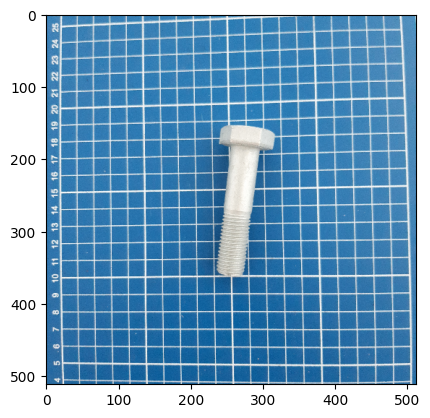

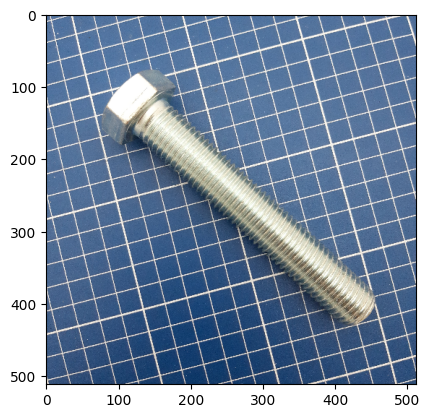

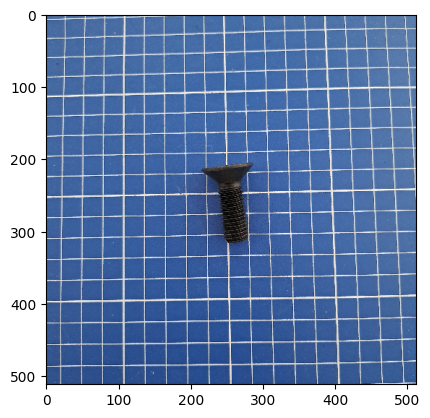

In [5]:
import matplotlib.pyplot as plt

# print(train_images[random.randint(0, len(train_images))])
train_im = train_images[random.randint(0, len(train_images))].astype(np.short)
validation_im = validation_images[random.randint(0, len(validation_images))].astype(np.short)
test_im = test_images[random.randint(0, len(test_images))].astype(np.short)

plt.imshow(train_im); plt.show()
plt.imshow(validation_im); plt.show()
plt.imshow(test_im); plt.show()

### TF Datasets

In [12]:
# test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(batch_size)
del test_images, test_labels

def data_generator(X, y, batch_size):
    num_samples = X.shape[0]
    while True:
        for i in range(0, num_samples, batch_size):
            yield X[i:i+batch_size], y[i:i+batch_size]

train_generator = data_generator(train_images, train_labels, batch_size)
# train_dataset = tf.data.Dataset.from_generator(
#     lambda: train_generator,
#     output_signature=(
#         tf.TensorSpec(shape=(None, image_dimensions[0], image_dimensions[0], 3), dtype=tf.float32),
#         tf.TensorSpec(shape=(None, ), dtype=tf.float32)
#     )
# ).repeat()
del train_images, train_labels

validation_generator = data_generator(validation_images, validation_labels, batch_size)
# validation_dataset = tf.data.Dataset.from_generator(
#     lambda: validation_generator,
#     output_signature=(
#         tf.TensorSpec(shape=(None, image_dimensions[0], image_dimensions[0], 3), dtype=tf.float32),
#         tf.TensorSpec(shape=(None, ), dtype=tf.float32)
#     )
# ).repeat()
del validation_images, validation_labels

# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
# del train_images, train_labels

# validation_dataset = tf.data.Dataset.from_tensor_slices((validation_images, validation_labels)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
# del validation_images, validation_labels

NameError: name 'test_images' is not defined

# Network - Custom

In [8]:
from tensorflow import keras
from tensorflow.keras import layers
import gc

gc.collect() 
keras.backend.clear_session()

In [9]:
inputs = keras.Input(shape=(image_dimensions[0], image_dimensions[1], 3))
x = layers.Rescaling(1./255)(inputs)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
    ]
)

x = data_augmentation(x)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)  
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x) # 256
x = layers.BatchNormalization()(x)
# x = layers.MaxPooling2D(pool_size=2)(x)

# x = layers.Conv2D(filters=512, kernel_size=3, activation="relu")(x)
# x = layers.BatchNormalization()(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)  

outputs = layers.Dense(142, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 60, 60, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 142)            │        72,846 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,645,390 (6.28 MB)

 Trainable params: 1,643,406 (6.27 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [10]:
model.compile(loss="sparse_categorical_crossentropy",
            optimizer=keras.optimizers.Adam(),
            metrics=["accuracy"])

# Network - More Complex Version

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
import gc

gc.collect() 
keras.backend.clear_session()

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(image_dimensions[0], image_dimensions[1], 3))
x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)

# First is regular convolution because RGB IS CORRELATED
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512, 1024, 2048]:
  residual = x
  
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)
  x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
  
  residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)
  x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.3)(x)

# # New Dense layer before the output layer
# x = layers.Dense(256, activation="relu")(x)
# x = layers.Dropout(0.3)(x)

outputs = layers.Dense(142, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 196, 196,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 196, 196,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 196, 196,  │          0 │ sequential[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 192, 192,  │      2,400 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 192, 192,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 192, 192,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d    │ (None, 192, 192,  │      1,312 │ activation[0][0]  │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 192,  │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 192, 192,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_1  │ (None, 192, 192,  │      1,312 │ activation_1[0][… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 96, 96,    │          0 │ separable_conv2d… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 96, 96,    │      1,024 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 96, 96,    │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 96,    │        128 │ add[0][0]         │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 96, 96,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 96, 96,    │      2,336 │ activation_2[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 96,    │        256 │ separable_conv2d

 Total params: 11,557,966 (44.09 MB)

 Trainable params: 11,545,742 (44.04 MB)

 Non-trainable params: 12,224 (47.75 KB)

In [8]:
model.compile(loss="sparse_categorical_crossentropy",
            optimizer=keras.optimizers.Adam(),
            metrics=["accuracy"])

# Network - Fine-Tuned

### Prepare

In [7]:
import tensorflow.keras as keras
from tensorflow.keras import layers
from keras.applications import InceptionResNetV2, ResNet50V2, EfficientNetB0
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, AveragePooling2D, Flatten, Dropout
import gc


gc.collect() 
keras.backend.clear_session()

### Main

In [8]:
conv_base = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(image_dimensions[0], image_dimensions[1], 3)
)

# Freeze the convolutional base
conv_base.trainable = False

# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.3),
        layers.RandomZoom(0.3),
    ]
)

# Model architecture
inputs = keras.Input(shape=(image_dimensions[0], image_dimensions[1], 3))
x = data_augmentation(inputs)
x = keras.applications.efficientnet.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()
# conv_base.summary()

2024-06-14 03:25:36.197209: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-14 03:25:36.201860: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-14 03:25:36.210404: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 16, 16, 1280)   │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 142)            │       181,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,231,473 (16.14 MB)

 Trainable params: 181,902 (710.55 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [9]:
model.compile(loss="sparse_categorical_crossentropy",
            optimizer="adam",
            metrics=["accuracy"])

In [10]:
import math
# Train classifier, then top convolution layers consecutively

epochs = 10

if include_other_class is True:
    save_filepath = f'./models/142_class/fastener_net_{str(image_dimensions[0])}_pretrained.keras'
else:
    save_filepath = f'./models/142_class/fastener_net_{str(image_dimensions[0])}_NO_OTHER_pretrained.keras'

print(save_filepath)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=save_filepath,
        save_best_only=True,
        monitor='val_loss')
]

model.fit(train_generator,
        steps_per_epoch=math.ceil(train_set_len / batch_size),
        epochs=int(epochs),
        validation_data=validation_generator,
        validation_steps=math.ceil(validation_set_len / batch_size),
        callbacks=callbacks)

./models/142_class/fastener_net_512_pretrained.keras
Epoch 1/10


2024-06-14 02:03:40.176242: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-14 02:03:42.242530: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


368/368 ━━━━━━━━━━━━━━━━━━━━ 160s 409ms/step - accuracy: 0.1346 - loss: 4.0712 - val_accuracy: 0.2912 - val_loss: 2.8603
Epoch 2/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 146s 398ms/step - accuracy: 0.3327 - loss: 2.8080 - val_accuracy: 0.3786 - val_loss: 2.3207
Epoch 3/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 147s 399ms/step - accuracy: 0.4094 - loss: 2.3680 - val_accuracy: 0.4262 - val_loss: 2.0561
Epoch 4/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 147s 400ms/step - accuracy: 0.4555 - loss: 2.1106 - val_accuracy: 0.4621 - val_loss: 1.9033
Epoch 5/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 147s 399ms/step - accuracy: 0.4862 - loss: 1.9365 - val_accuracy: 0.5043 - val_loss: 1.7419
Epoch 6/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 147s 401ms/step - accuracy: 0.5143 - loss: 1.8113 - val_accuracy: 0.5238 - val_loss: 1.6584
Epoch 7/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 146s 398ms/step - accuracy: 0.5489 - loss: 1.6696 - val_accuracy: 0.5269 - val_loss: 1.6062
Epoch 8/10
368/368 ━━━━━━━━━━━━━━━━━━━━ 147s 400ms/step - accuracy: 0.5587 - loss: 1.60

In [12]:
# model = keras.models.load_model(f'./models/142_class/fastener_net_{str(image_dimensions[0])}_fine_tuned.keras')

print(len(model.layers))
print(len(conv_base.layers))
print(len(model.trainable_weights))

5
238
2


In [11]:
# finetuned_model_filepath = f'./models/142_class/fastener_net_{str(image_dimensions[0])}_{str(int(dataset_percent*100))}_fine_tuned.keras'

epochs = input('Epochs: ')

if include_other_class is True:
    save_filepath = f'./models/142_class/fastener_net_{str(image_dimensions[0])}_fine_tuned.keras'
else:
    save_filepath = f'./models/142_class/fastener_net_{str(image_dimensions[0])}_NO_OTHER_fine_tuned.keras'

print(save_filepath)

conv_base.trainable = True
for layer in conv_base.layers[:-16]:
  layer.trainable = False

model.compile(loss="sparse_categorical_crossentropy",
            optimizer="adam",
            metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=save_filepath,
        save_best_only=True,
        monitor='val_loss')
]

history = model.fit(train_generator,
                  steps_per_epoch=math.ceil(train_set_len / batch_size),
                  epochs=int(epochs),
                  validation_data=validation_generator,
                  validation_steps=math.ceil(validation_set_len / batch_size),
                  callbacks=callbacks)

./models/142_class/fastener_net_512_fine_tuned.keras
Epoch 1/20


2024-06-14 02:28:51.296266: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


368/368 ━━━━━━━━━━━━━━━━━━━━ 171s 440ms/step - accuracy: 0.5571 - loss: 1.4376 - val_accuracy: 0.5980 - val_loss: 1.4365
Epoch 2/20
368/368 ━━━━━━━━━━━━━━━━━━━━ 161s 437ms/step - accuracy: 0.6815 - loss: 0.9602 - val_accuracy: 0.6456 - val_loss: 1.1622
Epoch 3/20
368/368 ━━━━━━━━━━━━━━━━━━━━ 161s 439ms/step - accuracy: 0.7245 - loss: 0.7978 - val_accuracy: 0.6425 - val_loss: 1.3644
Epoch 4/20
368/368 ━━━━━━━━━━━━━━━━━━━━ 153s 415ms/step - accuracy: 0.7651 - loss: 0.6812 - val_accuracy: 0.6347 - val_loss: 1.3348
Epoch 5/20
368/368 ━━━━━━━━━━━━━━━━━━━━ 154s 419ms/step - accuracy: 0.7836 - loss: 0.6105 - val_accuracy: 0.6667 - val_loss: 1.0857
Epoch 6/20
368/368 ━━━━━━━━━━━━━━━━━━━━ 157s 426ms/step - accuracy: 0.7891 - loss: 0.5979 - val_accuracy: 0.7127 - val_loss: 0.9256
Epoch 7/20
368/368 ━━━━━━━━━━━━━━━━━━━━ 154s 418ms/step - accuracy: 0.8039 - loss: 0.5444 - val_accuracy: 0.7299 - val_loss: 0.9241
Epoch 8/20
368/368 ━━━━━━━━━━━━━━━━━━━━ 157s 428ms/step - accuracy: 0.8309 - loss: 0.48

2024-06-14 03:14:49.275543: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:308] gpu_async_0 cuMemAllocAsync failed to allocate 405805056 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 452853760/3892510720
2024-06-14 03:14:49.275616: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:313] Stats: Limit:                      2317287424
InUse:                       431775180
MaxInUse:                   1871399308
NumAllocs:                     6332956
MaxAllocSize:                973930496
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-06-14 03:14:49.276190: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:62] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-06-14 03:14:49.276214: E external/local_xla/xla/stream_executor/g

ResourceExhaustedError: Graph execution error:

Detected at node functional_2_1/efficientnetb0_1/block2a_dwconv_pad_1/Pad defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/ipykernel_launcher.py", line 18, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 604, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_108/403133064.py", line 27, in <module>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 323, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 105, in one_step_on_data

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 56, in train_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 816, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 42, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 157, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 188, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/function.py", line 153, in _run_through_graph

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 572, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 816, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 42, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 157, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 188, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/function.py", line 153, in _run_through_graph

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 572, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 816, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 42, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 157, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/zero_padding2d.py", line 114, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/numpy.py", line 4202, in pad

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 42, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 157, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/numpy.py", line 4140, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/numpy.py", line 1203, in pad

OOM when allocating tensor with shape[16,257,257,96] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator gpu_async_0
	 [[{{node functional_2_1/efficientnetb0_1/block2a_dwconv_pad_1/Pad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_94953]

### Crash

In [14]:
import math

if include_other_class is True:
    test_model = keras.models.load_model(f'./models/142_class/fastener_net_{str(image_dimensions[0])}_fine_tuned.keras')
else:
    test_model = keras.models.load_model(f'./models/142_class/fastener_net_{str(image_dimensions[0])}_NO_OTHER_fine_tuned.keras')

# print(len(test_model.layers[2].layers))
# print(len(conv_base.layers))
# print(len(test_model.trainable_weights))

print(len(test_model.layers[2].trainable_weights))

test_model.layers[2].trainable = True
for layer in test_model.layers[2].layers[:-16]:
  layer.trainable = False

test_model.compile(loss="sparse_categorical_crossentropy",
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            metrics=["accuracy"])

print(len(test_model.layers[2].trainable_weights))

epochs = input('Epochs')

if include_other_class is True:
    save_filepath = f'./models/142_class/fastener_net_{str(image_dimensions[0])}_fine_tuned_new.keras'
else:
    save_filepath = f'./models/142_class/fastener_net_{str(image_dimensions[0])}_NO_OTHER_fine_tuned_new.keras'

print(save_filepath)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=save_filepath,
        save_best_only=True,
        monitor='val_loss')
]

history = test_model.fit(train_generator,
                  steps_per_epoch=math.ceil(train_set_len / batch_size),
                  epochs=int(epochs),
                  validation_data=validation_generator,
                  validation_steps=math.ceil(validation_set_len / batch_size),
                  callbacks=callbacks)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 432 variables whereas the saved optimizer has 38 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 428 variables whereas the saved optimizer has 0 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


211
0
./models/142_class/fastener_net_512_fine_tuned_new.keras
Epoch 1/10


2024-06-14 03:29:22.953687: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_2_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-14 03:29:26.206665: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:308] gpu_async_0 cuMemAllocAsync failed to allocate 150994944 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 90046464/3892510720
2024-06-14 03:29:26.206699: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:313] Stats: Limit:                      2222456832
InUse:                      3180782256
MaxInUse:                   3180782832
NumAllocs:                        8659
MaxAllocSize:                405805056
Reserved:                            0
PeakReserved:              

ResourceExhaustedError: Graph execution error:

Detected at node functional_2_1/efficientnetb0_1/block2b_expand_activation_1/Sigmoid defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/ipykernel_launcher.py", line 18, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 604, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_523/3506275432.py", line 40, in <module>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 323, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 105, in one_step_on_data

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 56, in train_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 814, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 42, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 157, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 188, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/function.py", line 153, in _run_through_graph

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 572, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 816, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 42, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 157, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 188, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/function.py", line 153, in _run_through_graph

  File "/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py", line 572, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py", line 814, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/operation.py", line 42, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 157, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/activation.py", line 31, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/activations/activations.py", line 277, in silu

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py", line 214, in silu

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py", line 43, in silu

failed to allocate memory
	 [[{{node functional_2_1/efficientnetb0_1/block2b_expand_activation_1/Sigmoid}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_145036]

# Training

In [9]:
# test_model = keras.models.load_model(model_filepath)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=model_filepath,
        save_best_only=True,
        monitor='val_loss')
]

history = model.fit(train_dataset,
                    epochs=25,
                    validation_data=validation_dataset,
                    callbacks=callbacks)

Epoch 1/25


2024-05-30 20:40:09.394098: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1360963632 exceeds 10% of free system memory.
2024-05-30 20:40:18.923552: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


1477/1477 ━━━━━━━━━━━━━━━━━━━━ 208s 133ms/step - accuracy: 0.0738 - loss: 4.2748 - val_accuracy: 0.0352 - val_loss: 7.3877
Epoch 2/25
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 193s 130ms/step - accuracy: 0.1776 - loss: 3.1138 - val_accuracy: 0.0857 - val_loss: 5.4146
Epoch 3/25
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 194s 132ms/step - accuracy: 0.2371 - loss: 2.7257 - val_accuracy: 0.1459 - val_loss: 4.2170
Epoch 4/25
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 194s 132ms/step - accuracy: 0.2787 - loss: 2.4706 - val_accuracy: 0.0493 - val_loss: 7.9822
Epoch 5/25
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 194s 131ms/step - accuracy: 0.3078 - loss: 2.3289 - val_accuracy: 0.0994 - val_loss: 6.9115
Epoch 6/25
 986/1477 ━━━━━━━━━━━━━━━━━━━━ 1:02 127ms/step - accuracy: 0.3312 - loss: 2.2750

2024-05-30 20:58:38.656564: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:308] gpu_async_0 cuMemAllocAsync failed to allocate 16777216 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 54001664/3892510720
2024-05-30 20:58:38.656643: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:313] Stats: Limit:                      2358706176
InUse:                      2318051137
MaxInUse:                   2712284781
NumAllocs:                    10273792
MaxAllocSize:               1360963632
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-05-30 20:58:38.657174: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:62] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-05-30 20:58:38.657196: E external/local_xla/xla/stream_executor/gpu

ResourceExhaustedError: Graph execution error:

Detected at node adam/Sqrt_125 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/ipykernel_launcher.py", line 18, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 604, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_4090/223067154.py", line 10, in <module>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 323, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 105, in one_step_on_data

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 72, in train_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py", line 269, in apply_gradients

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py", line 330, in apply

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py", line 380, in _backend_apply_gradients

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/optimizer.py", line 107, in _backend_update_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/optimizer.py", line 121, in _distributed_tf_update_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/optimizer.py", line 118, in apply_grad_to_update_var

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/adam.py", line 144, in update_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/numpy.py", line 5723, in sqrt

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/sparse.py", line 385, in sparse_wrapper

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/numpy.py", line 1744, in sqrt

failed to allocate memory
	 [[{{node adam/Sqrt_125}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_13295]

### Optional: Train starting from best validation accuracy model if memory overflow happened

In [8]:
model_filepath_new_2 = f'./models/142_class/fastener_net_142_{str(image_dimensions[0])}_{str(int(dataset_percent*100))}:bigger_new_2.keras'
test_model = keras.models.load_model(model_filepath_new_2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=model_filepath_new_2,
        save_best_only=True,
        monitor='val_loss')
]

test_model.fit(train_dataset,
                epochs=25,
                validation_data=validation_dataset,
                callbacks=callbacks)

Epoch 1/25


2024-05-30 20:19:32.935858: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1360963632 exceeds 10% of free system memory.
2024-05-30 20:19:39.424349: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


1477/1477 ━━━━━━━━━━━━━━━━━━━━ 179s 115ms/step - accuracy: 0.5889 - loss: 1.4963 - val_accuracy: 0.4233 - val_loss: 2.7991
Epoch 2/25
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 169s 114ms/step - accuracy: 0.6557 - loss: 1.0655 - val_accuracy: 0.4816 - val_loss: 2.1996
Epoch 3/25
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 168s 114ms/step - accuracy: 0.6529 - loss: 1.0898 - val_accuracy: 0.4714 - val_loss: 2.3536
Epoch 4/25
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 171s 116ms/step - accuracy: 0.6712 - loss: 1.0227 - val_accuracy: 0.4581 - val_loss: 2.5112
Epoch 5/25
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 171s 116ms/step - accuracy: 0.6417 - loss: 1.1503 - val_accuracy: 0.4664 - val_loss: 2.3986
Epoch 6/25
1477/1477 ━━━━━━━━━━━━━━━━━━━━ 173s 117ms/step - accuracy: 0.6722 - loss: 0.9962 - val_accuracy: 0.4487 - val_loss: 2.9470
Epoch 7/25
 835/1477 ━━━━━━━━━━━━━━━━━━━━ 1:13 114ms/step - accuracy: 0.6712 - loss: 1.0335

2024-05-30 20:38:20.004110: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:308] gpu_async_0 cuMemAllocAsync failed to allocate 4194304 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 72482816/3892510720
2024-05-30 20:38:20.004178: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:313] Stats: Limit:                      2301034496
InUse:                      2187289285
MaxInUse:                   2609480921
NumAllocs:                    10346919
MaxAllocSize:               1360963632
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-05-30 20:38:20.004759: E external/local_xla/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:62] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-05-30 20:38:20.004784: E external/local_xla/xla/stream_executor/gpu/

ResourceExhaustedError: Graph execution error:

Detected at node adam/Sub_214 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/ipykernel_launcher.py", line 18, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 604, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_123/3953225555.py", line 11, in <module>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 118, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 323, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 117, in one_step_on_iterator

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 105, in one_step_on_data

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 72, in train_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py", line 269, in apply_gradients

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py", line 330, in apply

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py", line 380, in _backend_apply_gradients

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/optimizer.py", line 107, in _backend_update_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/optimizer.py", line 121, in _distributed_tf_update_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/optimizer.py", line 118, in apply_grad_to_update_var

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/adam.py", line 129, in update_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/numpy.py", line 5467, in subtract

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/sparse.py", line 491, in sparse_wrapper

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/numpy.py", line 108, in subtract

failed to allocate memory
	 [[{{node adam/Sub_214}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_one_step_on_iterator_9484]

# Results

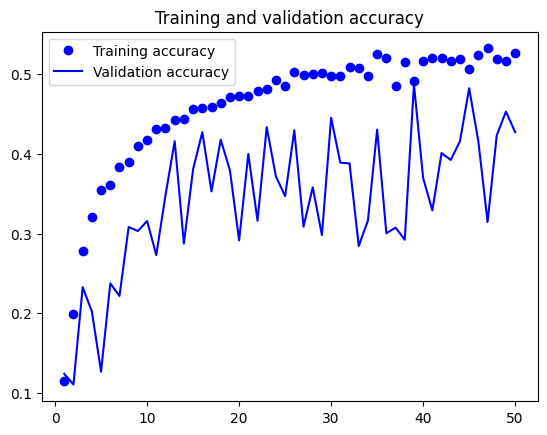

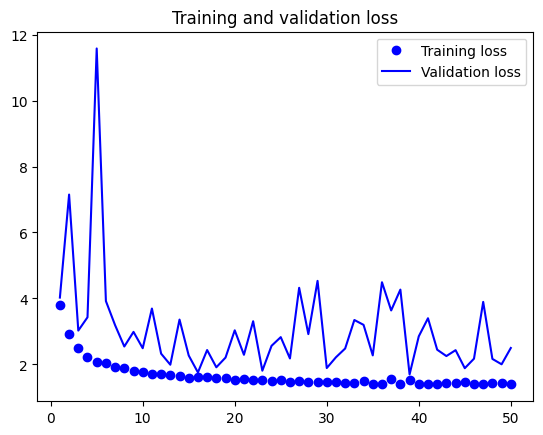

In [16]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.savefig(f'{model_results_filepath}/accuracy_history.png')
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.savefig(f'{model_results_filepath}/loss_history.png')
plt.show()